In [48]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from wordcloud import WordCloud
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\judyw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [50]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()
#df.info()


,reviews
0,✅ Trip Verified | Despite boarding being the u...
1,"Not Verified | Flight cancelled, no crew! 9th..."
2,"Not Verified | The worst service ever, my bag..."
3,✅ Trip Verified | 4/4 flights we booked this ...
4,✅ Trip Verified | British Airways has a total...


In [51]:
df.to_csv("C:/Users/judyw/Downloads/BA_reviews.csv")

In [52]:
#data cleaning- start by splitting
#df = df[df['reviews'].str.contains('✅ Trip Verified')]
df['reviews'] = df['reviews'].astype(str)
df = df[df['reviews'].str.contains('✅ Trip Verified')]
df["reviews"] = df["reviews"].str.split('|', expand=True)[1]


In [53]:
df.head()

,reviews
0,Despite boarding being the usual free for all...
3,4/4 flights we booked this holiday were dela...
4,British Airways has a total lack of respect ...
5,"London Heathrow to Keflavik, Iceland in Busin..."
6,Mumbai to London Heathrow in Business Class o...


In [54]:
# Remove special characters and punctuation
df['reviews']= df['reviews'].map(lambda x: re.sub('[,/\.!"?]', '', x))
#convert into lowercase
df['reviews']= df['reviews'].map(lambda x: x.lower())
df['reviews'].head()

#join the clea=ned reviews together
long_string = ','.join(list(df['reviews'].values))


<>:2: DeprecationWarning: invalid escape sequence '\.'
<>:2: DeprecationWarning: invalid escape sequence '\.'
C:\Users\judyw\AppData\Local\Temp\ipykernel_10652\1326258090.py:2: DeprecationWarning: invalid escape sequence '\.'
  df['reviews']= df['reviews'].map(lambda x: re.sub('[,/\.!"?]', '', x))


C:\Users\judyw\PycharmProjects\pythonProject3\venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


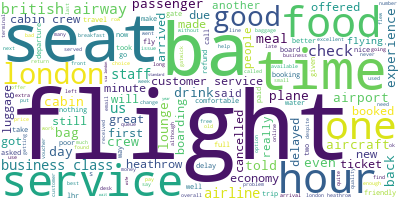

In [55]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [73]:
#remove stopwords
sw=stopwords.words('english')
stop_words = list(sw)
custom_stopwords =['from', 'for', 'my', 'our', 'no', 'I', 'was', 'to', 'a', 'or', 'at',
                   'despite', 'free', 'groups', 'called',
                   'whilst', 'agreed', 'getting', 'board', 
                   'anyone', 'else', 'however', 'impeccable', 'interacting', 'appearing']

stop_words = set(stopwords.words('english'))
stop_words.update(custom_stopwords)

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


In [74]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]


data = df.reviews.values.tolist()
data_words = list(sent_to_words(data))


In [75]:
# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

import gensim.corpora as corpora


['boarding', 'usual', 'lhr', 'passengers', 'check', 'bag', 'gate', 'service', 'superb', 'crew', 'friendly', 'attentive', 'passengers', 'generally', 'enjoying', 'job', 'like', 'ba', 'old', 'days', 'best', 'food', 'choice', 'quality', 'seems', 'improved', 'beef', 'cheeks', 'thankfully', 'even']


In [76]:
# Create Dictionary
idword = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
c = [idword.doc2bow(text) for text in texts]

# View
print(c[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2)]


In [70]:
#decide the numbeer of topics
n_topics = 5
#build the LDA model
model = gensim.models.LdaMulticore(corpus = c,
                                  id2word=idword,
                                  num_topics=n_topics)
#print the results of the model/ print the keywords in the model
pprint(model.print_topics())


[(0,
  '0.015*"flight" + 0.011*"service" + 0.011*"ba" + 0.011*"seat" + '
  '0.009*"economy" + 0.008*"seats" + 0.008*"london" + 0.007*"class" + '
  '0.007*"time" + 0.007*"cabin"'),
 (1,
  '0.021*"flight" + 0.016*"ba" + 0.007*"food" + 0.007*"service" + 0.006*"seat" '
  '+ 0.006*"staff" + 0.006*"cabin" + 0.006*"crew" + 0.006*"time" + '
  '0.005*"get"'),
 (2,
  '0.026*"flight" + 0.019*"ba" + 0.009*"london" + 0.008*"service" + '
  '0.006*"one" + 0.006*"seat" + 0.006*"business" + 0.006*"airways" + '
  '0.006*"class" + 0.005*"time"'),
 (3,
  '0.024*"flight" + 0.013*"ba" + 0.009*"service" + 0.009*"crew" + '
  '0.007*"class" + 0.007*"business" + 0.006*"one" + 0.006*"time" + '
  '0.006*"food" + 0.005*"cabin"'),
 (4,
  '0.026*"flight" + 0.011*"london" + 0.010*"ba" + 0.008*"good" + '
  '0.008*"service" + 0.007*"food" + 0.007*"us" + 0.007*"seat" + 0.006*"staff" '
  '+ 0.006*"time"')]


In [77]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = r'C:\Users\judyw\PycharmProjects\BritishAirways2\ldavis_prepared.pkl'

LDAvis_prepared = gensimvis.prepare(model, c, idword)
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_' + str(n_topics) + '.html')

print(LDAvis_prepared)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008420  0.005834       1        1  50.305657
4      0.000235 -0.017495       2        1  18.145168
3      0.007760  0.008325       3        1  16.486348
1      0.004852 -0.001480       4        1   7.780126
0     -0.021266  0.004817       5        1   7.282702, topic_info=            Term         Freq        Total Category  logprob  loglift
114         hour  1410.000000  1410.000000  Default  30.0000  30.0000
5           best   894.000000   894.000000  Default  29.0000  29.0000
48       holiday   494.000000   494.000000  Default  28.0000  28.0000
227       around   353.000000   353.000000  Default  27.0000  27.0000
305      support   176.000000   176.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
395    enquiring    13.191958   174.529680   Topic5  -5.7616   0.0368
115  information   